In [1]:
from datetime import datetime
from math import ceil
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

from alexnet import AlexNet
from image_loader import load_images
from util import shuffle, get_batch

### Set hyperparameters

In [2]:
np.random.seed(9002)

global_step = tf.Variable(0, trainable=False)
boundaries = [160, 320]
values = [0.0003, 0.0001, 0.00001]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

num_epochs = 3
batch_size = 128

dropout_rate = 0.5
num_classes = 1

# how often to write tf.summary to disk
display_step = 20

### Build computation graph

Building the CNN is in the `./alexnet.py` file. This is also used in `./eval.py` which just makes predictions, so it makes sense to put it in a separate file in order to reuse.

In [3]:
X = tf.placeholder(tf.float32, shape=(batch_size, 150, 150, 1), name="X")
Y = tf.placeholder(tf.float32, shape=(batch_size, num_classes), name="Y")
dropout = tf.placeholder(tf.float32, name="dropout_rate")

model = AlexNet(X, dropout, num_classes)

logits = tf.reshape(model.logits, (-1, 1))

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimization_op = optimizer.minimize(loss)

tf.summary.scalar('loss', loss)

with tf.name_scope("accuracy"):
    predictions = logits > 0
    correct_predictions = tf.equal(predictions, Y > 0)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.summary.scalar('training_accuracy', accuracy)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./tensorboard")
saver = tf.train.Saver()

### Load image data into memory

Only takes about 1-2GB of memory, so we can load it all into memory at once.

In [4]:
molecule_images = load_images(["./positives/images/*.png", "./positives/manually-collected/*.png"])
non_molecule_images = load_images(["./negatives/tiles/*.png", "./negatives/manually-collected/*.png"])

### Munge data

Generate the right labels, shuffle randomly, and partition training and test sets.

In [5]:
n_pos = molecule_images.shape[0]
n_neg = non_molecule_images.shape[0]

print("positives", n_pos)
print("negatives", n_neg)

positive_labels = np.ones(n_pos)
negative_labels = np.zeros(n_neg)

x = np.vstack((molecule_images, non_molecule_images))
y = np.concatenate((positive_labels, negative_labels)).reshape((-1, 1))

m = x.shape[0]

x, y = shuffle(x, y)

train_x = x[:-2000]
train_y = y[:-2000]

test_x = x[-2000:]
test_y = y[-2000:]

positives 12094
negatives 10398


### Preview
Display some labels and images.

[[ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


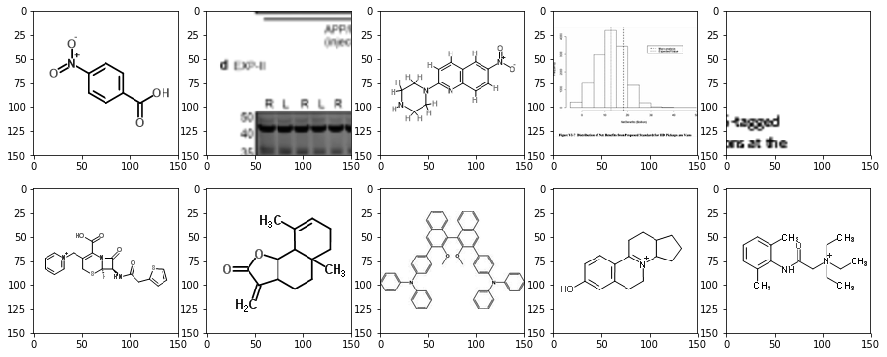

In [6]:
fig = plt.figure(figsize=(15, 6))
print(y[:10])
for j in range(10):
    sub = fig.add_subplot(2, 5, j + 1)
    sub.imshow(np.squeeze(x[j]), cmap="gray")

plt.show()

### Training

In [7]:
training_batches_per_epoch = int(np.floor(train_x.shape[0] / batch_size))
test_batches_per_epoch = int(np.floor(test_x.shape[0] / batch_size))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x, train_y = shuffle(train_x, train_y)
        
        for step in tqdm(range(training_batches_per_epoch)):
            x_batch, y_batch = get_batch(train_x, train_y, step, batch_size)
            sess.run(optimization_op, feed_dict={X: x_batch, Y: y_batch, dropout: dropout_rate })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(merged_summary, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
                writer.add_summary(summ, epoch * training_batches_per_epoch + step)
                writer.flush()

        test_acc = 0
        test_count = 0
        for step in range(test_batches_per_epoch):
            x_batch, y_batch = get_batch(test_x, test_y, step, batch_size)
            acc = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch, dropout: 0 })
            test_acc += acc
            test_count += 1

        print("test accuracy = {:.4f}".format(test_acc / test_count))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./tensorflow-ckpt/model.ckpt")

2018-01-09 00:48:39.436740 epoch number: 1


100%|██████████| 160/160 [03:48<00:00,  1.43s/it]


test accuracy = 0.9865
2018-01-09 00:52:34.578965 epoch number: 2


100%|██████████| 160/160 [03:34<00:00,  1.34s/it]


test accuracy = 0.9885
2018-01-09 00:56:15.386265 epoch number: 3


100%|██████████| 160/160 [03:34<00:00,  1.34s/it]


test accuracy = 0.9906


# Plotting some of the misclassified images

In [ ]:
# create a new graph which differs slightly from the previous
inference_graph = tf.Graph()
with inference_graph.as_default():
    # the LRN layer throws an error with too many images at once, so we'll limit to 10,000
    X = tf.placeholder(tf.float32, shape=(10000, 150, 150, 1), name="X")
    dropout = tf.constant(0)

    model = AlexNet(X, dropout, num_classes)
    
    predictions = model.logits > 0
    incorrect_predictions = tf.not_equal(tf.cast(predictions, tf.int32), y[:10000])
    
    saver = tf.train.Saver()
    
    # restore the model in this graph and see which predications were wrong
    with tf.Session() as sess:
        saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
        final_prediction_is_wrong = sess.run(incorrect_predictions, feed_dict={X: x[:10000]})

In [ ]:
# retrieve the images from x
indices_of_wrong_predictions = np.where(final_prediction_is_wrong)
misclassified_images = x[indices_of_wrong_predictions[0]]
num_misclassifieds = misclassified_images.shape[0]

# and plot them
fig = plt.figure(figsize=(15, 50))
for i in range(num_misclassifieds):
    sub = fig.add_subplot(ceil(num_misclassifieds / 5), 5, i + 1)
    sub.imshow(np.squeeze(misclassified_images[i, :, :]))
plt.show()

It looks like some of the most common false positives are "stick figure" people, and physics diagrams such as circuits or Feynman diagrams. False negatives seem to be because the molecule is too zoomed out.